# CNN XAI – Single-SMILES Attribution Inspector

This notebook loads the trained SMILES-CNN ensemble and computes a complete XAI explanation for **one molecule at a time**, including:

- Ensemble prediction probability (`pred_prob`)
- Predicted class (`pred_class`)
- Substructure-level attributions using **occlusion masking**
- A JSON-style attribution summary identical to the format in your activity-pair analysis
- A visualization that uses the same attribution rules

---

## 🔍 Attribution Threshold Rules

Every substructure gets an attribution score:

\[
\text{attribution} = P(\text{original}) - P(\text{masked})
\]

We classify substructures using the **same thresholds used in your CNN activity-pair analysis**:

### **Positive (> +0.10)**  
- Strongly increases predicted activity  
- Colored **cyan** in visualizations  

### **Negative (< –0.10)**  
- Strongly decreases predicted activity  
- Colored **orange**

### **Neutral (–0.10 to +0.10)**  
- Minimal influence  
- **No color overlay**

These thresholds also determine:
- `num_positive`, `num_negative`, `num_neutral`
- JSON fields:
  - `positive_substructures`
  - `negative_substructures`
  - `neutral_substructures`
- The visual highlight colors on the molecule.

This ensures **full consistency** between:  
**table → JSON → visualization**.


In [12]:
import os
import json
from typing import List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import torch
from rdkit import Chem

from config import Config
from data_preprocessing import SMILESPreprocessor
from model import SMILESCNNModel

# Correct local imports (because notebook lives inside CNN_model/)
from cnn_token_mapper import build_token_to_atoms
from cnn_viz_helper import visualize_with_substructures

# -------------------------
# 1. Basic configuration
# -------------------------

CKPT_DIR = "model_checkpoints"
SEQ_LEN = getattr(Config, "SEQ_LEN", 181)
PRED_THRESHOLD = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------
# 2. Load models and preprocessing
# -------------------------

def load_cnn_ensemble(ckpt_dir: str = CKPT_DIR) -> List[SMILESCNNModel]:
    """Load all CNN checkpoints in model_checkpoints/ as an ensemble."""
    models = []
    for f in sorted(os.listdir(ckpt_dir)):
        if f.endswith(".ckpt"):
            m = SMILESCNNModel.load_from_checkpoint(
                os.path.join(ckpt_dir, f),
                map_location=device,
            )
            m.eval()
            m.to(device)
            models.append(m)
    if not models:
        raise RuntimeError("No CNN checkpoints found.")
    return models


def prepare_input(preproc: SMILESPreprocessor, smiles: str, seq_len: int):
    """Convert SMILES → padded one-hot tensor ready for CNN."""
    encoded = preproc.encode_smiles(smiles)
    padded = preproc.pad_sequences([encoded], max_length=seq_len)
    one_hot = preproc.one_hot_encode(padded)
    return torch.from_numpy(one_hot).float().to(device)


@torch.no_grad()
def ensemble_predict_prob(models: List[SMILESCNNModel],
                          x_input: torch.Tensor) -> float:
    """Averaged sigmoid prediction across ensemble."""
    probs = []
    for m in models:
        logits = m(x_input)
        probs.append(torch.sigmoid(logits).item())
    return float(np.mean(probs))


# -------------------------
# 3. RDKit ring-based substructures
# -------------------------

def ring_or_murcko_substructures(smiles: str) -> Dict[str, List[int]]:
    """
    Extract ring substructures using RDKit's SymmSSSR.
    This aligns with your activity-pair CNN pipeline.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    rings = list(Chem.GetSymmSSSR(mol))
    out = {}
    for i, ring in enumerate(rings):
        atoms = [int(a) for a in list(ring)]
        if atoms:
            out[f"ring_{i}"] = atoms
    return out


# -------------------------
# 4. Substructure occlusion
# -------------------------

def substruct_json_single(
    smiles: str,
    x_input: torch.Tensor,
    base_prob: float,
    models: List[SMILESCNNModel],
    seq_len: int = SEQ_LEN,
) -> List[Dict[str, Any]]:

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    subs = ring_or_murcko_substructures(smiles)
    n_atoms = mol.GetNumAtoms()

    token_map = build_token_to_atoms(smiles)

    # Build atom → token bins
    if token_map:
        bins = [[] for _ in range(n_atoms)]
        for pos, atomlist in enumerate(token_map):
            if pos >= seq_len:
                break
            for a in atomlist:
                if 0 <= a < n_atoms:
                    bins[a].append(pos)
    else:
        # Equal partition fallback
        indices = list(range(seq_len))
        raw = np.array_split(indices, n_atoms)
        bins = [list(r.astype(int)) for r in raw]

    result = []
    for name, atoms in subs.items():
        if not atoms:
            continue

        pos_indices = sorted({p for a in atoms for p in bins[a]})
        if not pos_indices:
            continue

        x_mask = x_input.clone()
        x_mask[:, pos_indices, :] = 0
        x_mask[:, pos_indices, 0] = 1  # PAD token

        masked_prob = ensemble_predict_prob(models, x_mask)
        delta = base_prob - masked_prob
        per_atom = delta / max(1, len(atoms))

        if delta > 0.1:
            impact = "Increases probability of activity"
        elif delta < -0.1:
            impact = "Decreases probability of activity"
        else:
            impact = "Minimal impact on activity"

        frag = Chem.MolFragmentToSmiles(mol,
                                        atomsToUse=atoms,
                                        kekuleSmiles=True)

        result.append({
            "substructure": frag,
            "atoms": atoms,
            "attribution": float(delta),
            "attribution_per_atom": float(per_atom),
            "impact": impact,
        })

    result.sort(key=lambda d: abs(d["attribution"]), reverse=True)
    return result


# -------------------------
# 5. Partition substructures (fixed missing function)
# -------------------------

def partition_substructures(subs: List[Dict[str, Any]], thr: float = 0.1):
    """Split into positive / negative / neutral based on ±0.1 threshold."""
    pos, neg, neu = [], [], []
    for s in subs:
        v = float(s["attribution"])
        if v >= thr:
            pos.append(s)
        elif v <= -thr:
            neg.append(s)
        else:
            neu.append(s)
    return pos, neg, neu


# -------------------------
# 6. Build atom scores so visualization matches the table
# -------------------------

def atom_scores_from_substructures(
    smiles: str,
    pos_subs: List[Dict[str, Any]],
    neg_subs: List[Dict[str, Any]],
    include_neutral: bool = False,
    neu_subs: List[Dict[str, Any]] = None,
) -> np.ndarray:
    """
    Convert substructure attributions → atom-level scores.
    Only strong fragments (|attr| > 0.1) are included by default.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.array([])

    n_atoms = mol.GetNumAtoms()
    scores = np.zeros(n_atoms, dtype=float)

    use_list = []
    use_list.extend(pos_subs)
    use_list.extend(neg_subs)
    if include_neutral and neu_subs is not None:
        use_list.extend(neu_subs)

    for frag in use_list:
        per_atom = float(frag["attribution_per_atom"])
        for a in frag["atoms"]:
            if 0 <= a < n_atoms:
                scores[a] += per_atom

    return scores


# -------------------------
# 7. Load ensemble + preprocessor ONCE
# -------------------------

models_ensemble = load_cnn_ensemble()
preproc = SMILESPreprocessor()


# -------------------------
# 8. High-level single-SMILES API
# -------------------------

def analyze_single_smiles(smiles: str):
    """
    Returns:
      - DataFrame (1 row) with prediction + attribution fields
      - SVG visualization colored by atom_scores
    """

    x = prepare_input(preproc, smiles, SEQ_LEN)
    prob = ensemble_predict_prob(models_ensemble, x)
    pred_class = "active" if prob >= PRED_THRESHOLD else "inactive"

    subs = substruct_json_single(smiles, x, prob, models_ensemble, SEQ_LEN)
    pos, neg, neu = partition_substructures(subs)

    atom_scores = atom_scores_from_substructures(
        smiles,
        pos_subs=pos,
        neg_subs=neg,
        include_neutral=False,
        neu_subs=neu,
    )

    df = pd.DataFrame([{
        "smiles": smiles,
        "pred_prob": prob,
        "pred_class": pred_class,
        "num_positive": len(pos),
        "num_negative": len(neg),
        "num_neutral": len(neu),
        "positive_features": "",
        "negative_features": "",
        "neutral_features": "",
        "positive_substructures": json.dumps(pos),
        "negative_substructures": json.dumps(neg),
        "neutral_substructures": json.dumps(neu),
    }])

    svg = visualize_with_substructures(
        smiles=smiles,
        atom_scores=atom_scores,
        pred_prob=prob,
        prediction=pred_class.capitalize(),
    )

    return df, svg


Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\uqaonawo\OneDrive - The University of Queensland\Desktop\Zenodo2\CNN_model\model_checkpoints\CV1_Fold5_best-epoch=67-val_auroc=0.8465.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\uqaonawo\OneDrive - The University of Queensland\Desktop\Zenodo2\CNN_model\model_checkpoints\CV2_Fold5_best-epoch=66-val_auroc=0.8442.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\uqaonawo\OneDrive - The University of Queensland\Desktop\Zenodo2\CNN_model\model_checkpoints\CV2_Fold5_best-epoch=66-val_auroc

## Step 2 – Paste Your SMILES Below

In the next cell, set the `SMILES` string and run the cell.

The notebook will output:

- A single-row prediction + attribution table  
- JSON lists containing positive / negative / neutral substructures  
- A visualization colored according to attribution thresholds  


[VIZ DEBUG] Starting visualization
[VIZ DEBUG] atom_scores type: <class 'numpy.ndarray'>, shape: (23,)
[VIZ DEBUG] Molecule has 23 atoms
[VIZ DEBUG] atom_scores length: 23
[VIZ DEBUG] Normalization: max=0.1053, p95=0.1003, denom=0.1003
[VIZ DEBUG] Colored 7 atoms
[VIZ DEBUG] Colored 13 bonds
[VIZ DEBUG] Successfully created SVG
SMILES: CC1(C)SC2C(NC(=O)CC3=CC=CC=C3)C(=O)N2[C@H]1C(=O)O



Substructure attribution summary:


,Substructure,Attribution,Status
0,C1CNCS1,0.250,Positive
1,C1CCN1,0.221,Positive
2,C1=CC=CC=C1,-0.063,Neutral


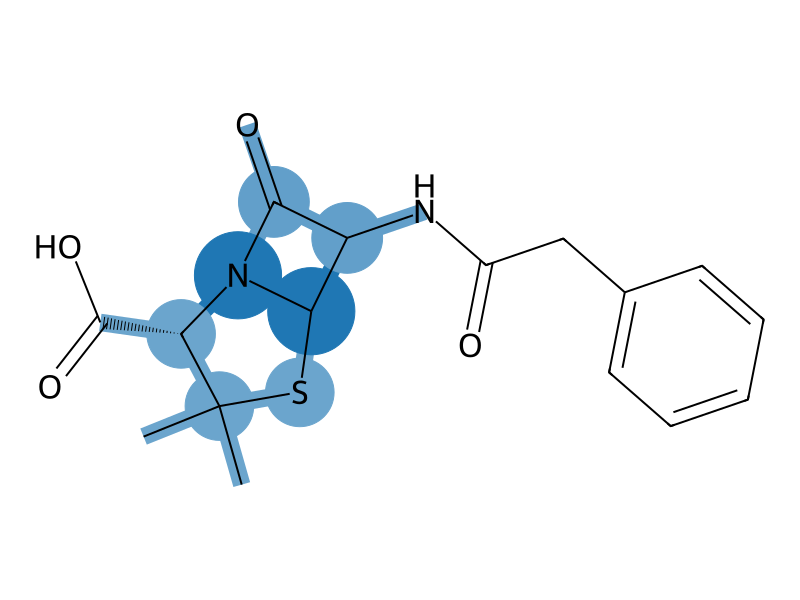

In [14]:
import json
import pandas as pd
from IPython.display import display, SVG, HTML

# 🔹 PASTE SMILES HERE
SMILES = "CC1(C)SC2C(NC(=O)CC3=CC=CC=C3)C(=O)N2[C@H]1C(=O)O"

# Run analysis (Cell 2 must have been executed first)
df, svg = analyze_single_smiles(SMILES)

# ---- 1. Nice textual summary ----
row = df.iloc[0]

smiles_str = row["smiles"]
pred_prob = float(row["pred_prob"])
pred_class = row["pred_class"]

print(f"SMILES: {smiles_str}")
display(HTML(f"<h2 style='font-weight:bold; text-transform:uppercase;'>PREDICTED PROBABILITY OF ACTIVITY: {pred_prob:.3f}</h2>"))
display(HTML(f"<h2 style='font-weight:bold; text-transform:uppercase;'>PREDICTED CLASS (THRESHOLD = 0.5): {pred_class.upper()}</h2>"))
print()  # blank line

# ---- 2. Build compact substructure summary table ----
pos_list = json.loads(row["positive_substructures"]) if row["positive_substructures"] else []
neg_list = json.loads(row["negative_substructures"]) if row["negative_substructures"] else []
neu_list = json.loads(row["neutral_substructures"]) if row["neutral_substructures"] else []

summary_rows = []

for frag in pos_list:
    summary_rows.append(
        {
            "Substructure": frag["substructure"],
            "Attribution": float(frag["attribution"]),
            "Status": "Positive",
        }
    )

for frag in neg_list:
    summary_rows.append(
        {
            "Substructure": frag["substructure"],
            "Attribution": float(frag["attribution"]),
            "Status": "Negative",
        }
    )

for frag in neu_list:
    summary_rows.append(
        {
            "Substructure": frag["substructure"],
            "Attribution": float(frag["attribution"]),
            "Status": "Neutral",
        }
    )

sub_df = pd.DataFrame(summary_rows)

# Sort by absolute attribution (strongest first)
if not sub_df.empty:
    sub_df = sub_df.reindex(
        sub_df["Attribution"].abs().sort_values(ascending=False).index
    )
    # format attribution to 3 d.p. for display
    sub_df["Attribution"] = sub_df["Attribution"].map(lambda x: f"{x:.3f}")

print("Substructure attribution summary:")
display(sub_df)



# ---- 4. Show visualization ----
if svg is not None:
    display(SVG(svg))
